# NBA Python project

<b style="color:red">
    <br>
    Nicolas BOUILLET<br><br>
    Constance DECROOCQ<br><br>
    Arthur POURRIER<br><br>
    Emmy VANDEVILLE
</b>

## Summary of the functionalities

1. Scrap players and teams
2. Boxplot of the 3 points percentage in function of the height
3. Plot percentage of wins in function of points of teams
4. Histogram of the number of turnovers
5. Plot of the free throw percentage in function of the experience of a player
6. Correlation's heatmap of the player statistics
7. Predict the free throw percentage of a player with a given experience

## Library

In [2]:
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from selenium import webdriver
from bs4 import BeautifulSoup
from enum import Enum
import time
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

## Scraping

We chose to focus on the 2021/2022 statistics as they are the more recent values and it simplifies the storage since there is only one year to collect and store.

All of the data is stored in a csv file.

### Player scrap

 We scraped from this page : https://www.nba.com/players

We chose to scrap about the player :
- the number of games played
- the points he made
- the percentage of field goals, 3 points and free throw to see if try to make goals
- the average number of rebounds, assists, turnovers, steals and blocks as they are the main actions in a game

In [4]:
# This cell may take a while to run, please be patient

chrome_options = Options()
chrome_options.add_argument("--headless")
browser = webdriver.Chrome(options=chrome_options)
browser.delete_all_cookies()
browser.get("https://www.nba.com/stats/players/traditional/?PerMode=Totals&sort=PTS&dir=-1")
time.sleep(5)
# cookie's button
button = browser.find_element(By.ID, "onetrust-accept-btn-handler")
button.click()
# get tab element
player = browser.find_element(By.CLASS_NAME, 'nba-stat-table__overflow')
# Traditional : GP, PTS, FG%, 3P%, FT%, REB, AST, TOV, STL, BLK
data = []
fLine = []
header = player.find_elements_by_tag_name("th")
test = lambda a: a == 8 or a == 11 or a == 14 or a == 17 or a == 20 or a == 21 or a == 22 or a == 23 or a == 24
# get all categories we need
for i in range(len(header)):
    if test(i):
        fLine.append(header[i].text)
#iterate over all players pages
flag = 0
while(not flag == 10):
    time.sleep(5)
    player1 = browser.find_element(By.CLASS_NAME, 'nba-stat-table__overflow')
    tab = player1.find_elements_by_tag_name("tr")
    #get all the info we need
    for i in range(1, len(tab)):
        currLine = []
        lines = tab[i].find_elements_by_tag_name("td")
        for j in range(len(lines)):
            if test(j):
                currLine.append(lines[j].text)
        data.append(currLine)
        #go to the next page
    button = browser.find_element_by_class_name("stats-table-pagination__next")
    button.click()
    flag =flag + 1
browser.quit()
#write into a csv file the data we scraped
with open('player.csv', 'w', newline='') as playercsv:
    writer = csv.writer(playercsv)
    for line in data:
        writer.writerow(line)



NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":".nba-stat-table__overflow"}
  (Session info: headless chrome=96.0.4664.110)
Stacktrace:
Backtrace:
	Ordinal0 [0x00E86903+2517251]
	Ordinal0 [0x00E1F8E1+2095329]
	Ordinal0 [0x00D22848+1058888]
	Ordinal0 [0x00D4D448+1233992]
	Ordinal0 [0x00D4D63B+1234491]
	Ordinal0 [0x00D77812+1406994]
	Ordinal0 [0x00D6650A+1336586]
	Ordinal0 [0x00D75BBF+1399743]
	Ordinal0 [0x00D6639B+1336219]
	Ordinal0 [0x00D427A7+1189799]
	Ordinal0 [0x00D43609+1193481]
	GetHandleVerifier [0x01015904+1577972]
	GetHandleVerifier [0x010C0B97+2279047]
	GetHandleVerifier [0x00F16D09+534521]
	GetHandleVerifier [0x00F15DB9+530601]
	Ordinal0 [0x00E24FF9+2117625]
	Ordinal0 [0x00E298A8+2136232]
	Ordinal0 [0x00E299E2+2136546]
	Ordinal0 [0x00E33541+2176321]
	BaseThreadInitThunk [0x7592FA29+25]
	RtlGetAppContainerNamedObjectPath [0x77AA7A9E+286]
	RtlGetAppContainerNamedObjectPath [0x77AA7A6E+238]


### Team scrap

We scraped from this page : https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1

We chose to scrap about the team :
- the name, games played and number of wins and losses (plus win percentage)
- the number of minute played to see if there is additionnal time (>48)
- the number of points, the percentage of field goals, 3 points and free throw
- the average number of rebounds, assists, turnovers, steals and blocks as they are the main actions in a game

In [29]:
# Open Chrome
browser = webdriver.Chrome()
# Go on the teams' page on the site
browser.get("https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1")

# Wait for the cookies pop up to appear
time.sleep(2)

# Accept the cookies
cookies = browser.find_element_by_id("onetrust-accept-btn-handler")
cookies.click()

# Declare names as a list
names = []

# Specify where we search the data
soup = BeautifulSoup(browser.page_source, "html.parser")
soup = soup.find("table")

# Get all element whose class is "first"
name = soup.find_all("td", {"class": "first"})

# For every element
for n in name:
    #  Add the name in the 'a' tag as a string
    names.append(n.find("a").get_text())

# Declare stats as a list
teams = []

# For every team
for i in range(len(names)):
    # Store all the data from the team
    l1 = soup.find_all("tr", {"index": str(i)})
    #Declare temporary list which will contain the data of one team
    p = []
    
    # Store every element in the 'td' tag 
    for l in l1:
        m1 = l.find_all("td")
        
        # For each 'td' element
        for m in m1:
            # Add it to the team's data
            p.append(m.get_text().strip())
                
    # Add all the team's data to the teams' stats list
    teams.append(p)

# Close Chrome
browser.quit()

# For each team
for s in teams:
    # Parse the rank to an int
    s[0] = int(s[0])
    # For each stat after the name
    for i in range(2, len(s)):
        # Parse the stat to a float
        s[i] = float(s[i])
        
# Create or open a csv file
with open('teams.csv', 'w', newline='') as mycsv:
    writer = csv.writer(mycsv)
    # Write the name of the data in the first line
    writer.writerow(['Team', 'Games_Played', 'Wins', 'Loses', 'WIN%', 'MIN', 'PTS', 'FG%', '3P%', 'FT%', 'Rebounds', 'Assists', 'Turnovers', 'Steals', 'Blocks'])
    # For each team
    for s in teams:
        # Store its useful data as a line in the csv file
        writer.writerow([s[1], s[2], s[3], s[4], s[5], s[6], s[7], s[10], s[13], s[16], s[19], s[20], s[21], s[22], s[23]])
    

C:\Users\Arthur\AppData\Local\Temp/ipykernel_7820/552790139.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  cookies = browser.find_element_by_id("onetrust-accept-btn-handler")


## Plot

In [4]:
# Reading of the csv player created by the scraping
player = pd.read_csv("player.csv")
player[:10]

,Height,Weight,Age,Player_Impact_Estimate,Experience,Games_Played,PTS,FG%,3P%,FT%,Rebounds,Assists,Turnovers,Steals,Blocks
0,2.03,102,22,8.2,1,22,8.4,40.3,28.6,58.8,8.1,1.5,1.1,0.5,0.5
1,2.11,120,28,10.7,8,31,7.2,53.2,0.0,61.7,8.9,2.7,1.7,1.0,0.6
2,1.88,84,33,16.5,12,28,27.0,43.0,39.8,92.9,5.5,6.1,3.4,1.6,0.5


In [5]:
# Reading of the csv teams created by the scraping
team = pd.read_csv("teams.csv")
team[:10]

,Team,Games_Played,Wins,Loses,WIN%,MIN,PTS,FG%,3P%,FT%,Rebounds,Assists,Turnovers,Steals,Blocks
0,Phoenix Suns,29.0,24.0,5.0,0.828,48.2,111.9,47.8,36.8,78.8,45.8,26.3,14.0,8.6,4.1
1,Golden State Warriors,30.0,24.0,6.0,0.800,48.2,111.4,46.9,36.2,75.6,46.9,28.0,16.1,9.2,4.9
2,Brooklyn Nets,30.0,21.0,9.0,0.700,48.2,109.7,46.4,35.3,81.6,45.5,25.3,14.2,6.8,5.3
3,Utah Jazz,29.0,20.0,9.0,0.690,48.0,115.6,48.1,37.1,77.4,46.7,22.7,14.6,7.2,5.3
4,Chicago Bulls,28.0,18.0,10.0,0.643,48.0,108.5,46.4,36.7,81.4,43.2,23.1,13.4,7.9,4.6
5,Cleveland Cavaliers,31.0,19.0,12.0,0.613,48.0,107.0,46.3,36.0,79.2,45.0,25.3,15.7,7.6,4.4
6,Memphis Grizzlies,31.0,19.0,12.0,0.613,48.3,111.1,45.3,34.8,75.1,47.1,25.3,13.6,10.4,5.9
7,Milwaukee Bucks,32.0,19.0,13.0,0.594,48.3,110.0,45.2,35.9,75.2,47.1,22.5,14.4,7.8,4.4
8,Miami Heat,31.0,18.0,13.0,0.581,48.3,106.6,46.0,36.5,78.8,44.0,25.2,15.0,7.1,3.1
9,LA Clippers,30.0,16.0,14.0,0.533,48.2,106.0,45.1,36.2,78.3,44.0,23.1,14.9,8.0,4.4


### Plot 1 : boxplot

We want to see if the more a player plays, the more he scores.

In [ ]:
sns.boxplot(y='3P%', x='Games_Played', data=player, palette="colorblind")

<AxesSubplot:xlabel='Games_Played', ylabel='3P%'>

Here we can see that

### Plot 2 : lineplot

We plot here the number of points scored in a game in function of the win percentage. We wanted to know if there were a correlation between the number of points and the percentage of games won.

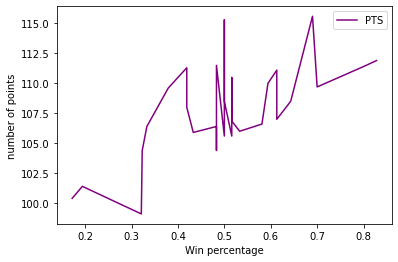

In [11]:
fig = team.plot(x="WIN%", y="PTS", c="Purple")
plt.xlabel('Win percentage')
plt.ylabel('number of points')
plt.show()

In [13]:
win = np.array(team[['WIN%']])
point = np.array(team[['PTS']])
win_reduce = []
point_reduce = []
for i in range (len(win)):
    win_reduce.append(float(win[[i][0]]))
for i in range (len(point)):
    point_reduce.append(float(point[[i][0]]))
print("pearson coefficient:\n",np.corrcoef(win_reduce, point_reduce))

pearson coefficient:
 [[1.         0.65737736]
 [0.65737736 1.        ]]


We can see that they are correlated with a Pearson's correlation of 0,66. So the more the team scores the more she has the possibility to win.

### Plot 3 : histogram

We plot here the number of turnovers by each team in order to see if they are following a distribution. 

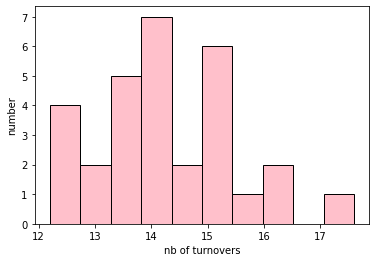

In [9]:
x = team['Turnovers']

fig = plt.hist(x,color = 'pink',
            edgecolor = 'black')
plt.xlabel('nb of turnovers')
plt.ylabel('number')
plt.show()

We can see that it could be approximated by a normal distribution.

### Plot 4 : Scattered plot 

We wanted to know if decissive passes (assists) are correlated to the stealing of the ball.

In [ ]:
fig = player.plot.scatter(x="Assists", y="Steals", c="Purple")

Here we can se that the values seem to be correlated

### Plot 5 : Correlation's heatmap

As the 2 values of plot 4 seem to be correlated, we are gonna check if they really are and show the Pearson's correlation of the different values of a player.

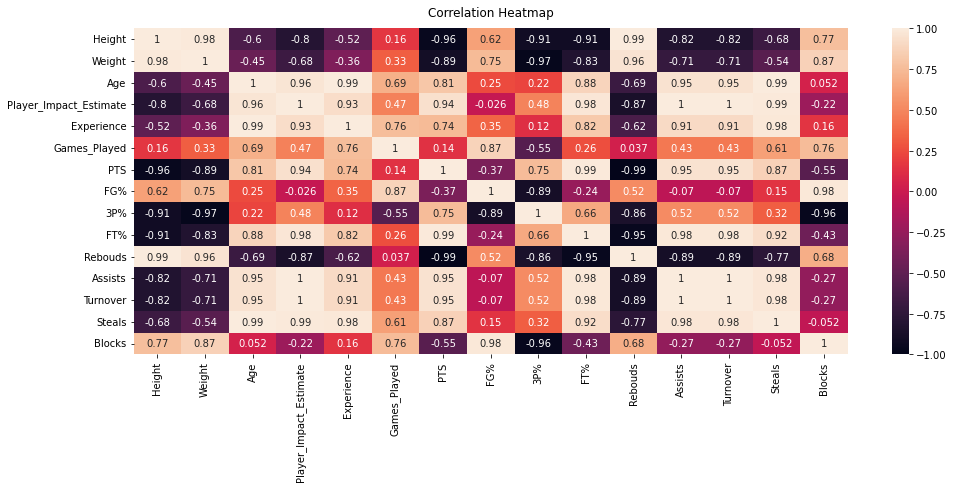

In [38]:
# Increase the size of the heatmap
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title)
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
heatmap = sns.heatmap(player.corr(method ='pearson'), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Here we see that assists and steals are correlated.

## Prediction

As our values are correlated we can predict the assists of a player from a given steals.

#### We convert our pandas dataframe to a numpy array to do a prediction.

In [48]:
data_player=player.to_numpy()
print(data_player)

[[  2.03 102.    22.     8.2    1.    22.     8.4   40.3   28.6   58.8
    8.1    1.5    1.1    0.5    0.5 ]
 [  2.11 120.    28.    10.7    8.    31.     7.2   53.2    0.    61.7
    8.9    2.7    1.7    1.     0.6 ]
 [  1.88  84.    33.    16.5   12.    28.    27.    43.    39.8   92.9
    5.5    6.1    3.4    1.6    0.5 ]]


#### We create a polynomial regression model to estimate the assists in function of steals.

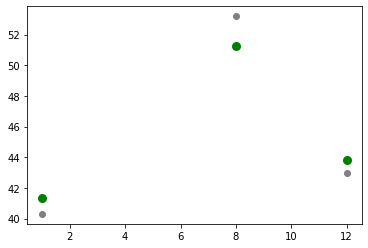

In [51]:
myReg = linear_model.LinearRegression()

X = data_player[:,6] # assists
X=X.reshape(-1,1)   
Y = data_player[:,8] # steals

poly =  make_pipeline(PolynomialFeatures(degree=2), Ridge())

poly.fit(X, Y)

Y_pred2 = poly.predict(X)

plt.scatter(X, Y,  color='grey')
plt.scatter(X, Y_pred2, color='green', linewidth=3)

plt.show()

#### We train our model.

In [50]:
myReg.fit(X,Y)   

LinearRegression()

#### We predict the assists of a player that had 0.5 of average steals.

In [52]:
poly.predict([[0.5]])

array([49.19422981])

## Drawbacks and difficulties

Drawbacks in your program and issues that can be upgraded, tasks that can be added to it

Difficulties encountered while doing the project

### Drawbacks

We could have used more of the values we thought were important but we didn't find wich plot was the most adpated to do so.

### Difficulties

As there was no specific id or class for the values in the different table it was really complicated to scrap.

For example we wanted to scrap :
- the height, weight and height of a player
- the Player Impact Estimate as it show how important can a player be in a game
- the experience to know if a experimented player is better

But in the end it was too difficult to get the values and scrap them.